In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime as dt

In [2]:
ds = pd.read_csv('../data/Metro_Interstate_Traffic_Volume.csv')
print(ds.dtypes)
ds.head(5)
ds

holiday                 object
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
date_time               object
traffic_volume           int64
dtype: object


holiday    temp  rain_1h  snow_1h  clouds_all  weather_main  \
0        None  288.28      0.0      0.0          40        Clouds   
1        None  289.36      0.0      0.0          75        Clouds   
2        None  289.58      0.0      0.0          90        Clouds   
3        None  290.13      0.0      0.0          90        Clouds   
4        None  291.14      0.0      0.0          75        Clouds   
...       ...     ...      ...      ...         ...           ...   
48199    None  283.45      0.0      0.0          75        Clouds   
48200    None  282.76      0.0      0.0          90        Clouds   
48201    None  282.73      0.0      0.0          90  Thunderstorm   
48202    None  282.09      0.0      0.0          90        Clouds   
48203    None  282.12      0.0      0.0          90        Clouds   

          weather_description            date_time  traffic_volume  
0            scattered clouds  2012-10-02 09:00:00            5545  
1               broken clouds  2012-10-02 10:00:00            4516  
2             overcast clouds  2012-10-02 11:00:00            4767  
3             overcast clouds  2012-10-02 12:00:00            5026  
4               broken clouds  2012-10-02 13:00:00            4918  
...                       ...                  ...             ...  
48199           broken clouds  2018-09-30 19:00:00            3543  
48200         overcast clouds  2018-09-30 20:00:00            2781  
48201  proximity thunderstorm  2018-09-30 21:00:00            2159  
48202         overcast clouds  2018-09-30 22:00:00            1450  
48203         overcast clouds  2018-09-30 23:00:00             954  

[48204 rows x 9 columns]

holiday: check whether different holidays have different effect on traffic. Then one-hot encode (2 classes or all)
temp: drop rows with 0. Normalize.
rain_1h: drop outlier (9831). Normalize.
snow_1h: Normalize.
clouds_all: Normalize
weather_main: one-hot
weather_description: drop column
date_time: deal with duplicates. Split into year (1-n) + Normalize, month (one-hot), day of week(one_hot), hour (cyclical)

In [3]:
ds[["holiday", "traffic_volume"]].groupby(['holiday']).mean().reset_index()

holiday  traffic_volume
0               Christmas Day      827.500000
1                Columbus Day      519.400000
2            Independence Day     1076.000000
3                   Labor Day     1013.142857
4   Martin Luther King Jr Day      612.666667
5                Memorial Day     1107.600000
6               New Years Day     1356.000000
7                        None     3262.852170
8                  State Fair      634.800000
9            Thanksgiving Day      933.500000
10               Veterans Day      691.400000
11       Washingtons Birthday      635.200000

In [4]:
ds["holiday"] = 0 + 1 * (ds["holiday"] != "None")

remove_positions = ds["temp"] == 0
ds = ds.drop(np.where(remove_positions)[0])

ds.drop(["weather_description"], axis=1, inplace=True)

ds = ds.loc[ds["rain_1h"] < 1000, :]

weather_main_one_hot = pd.get_dummies(ds.weather_main)
ds = pd.concat([ds, weather_main_one_hot], axis=1)
ds.drop(["weather_main"], axis=1, inplace=True)

date_time: deal with duplicates. Split into year (1 to n) + Normalize, month (one-hot), day of week(one_hot), hour (cyclical)

In [5]:
ds["date_time"] = pd.to_datetime(ds["date_time"])
ds = ds.groupby(["holiday", "temp", "rain_1h", "snow_1h", "clouds_all", "date_time", "traffic_volume"]).sum().reset_index()
ds = ds.drop_duplicates(subset=['date_time'])

In [6]:
ds.sort_values(by=['date_time'], inplace=True)
ds = ds.reset_index(drop=True)

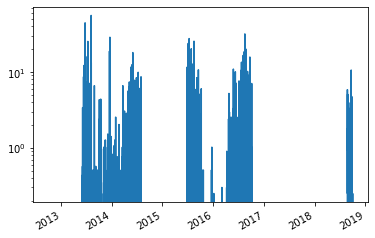

In [7]:
x = ds["date_time"]
y = ds["rain_1h"]

plt.semilogy(x, y)
plt.gcf().autofmt_xdate()

ds.drop(["rain_1h"], axis=1, inplace=True)

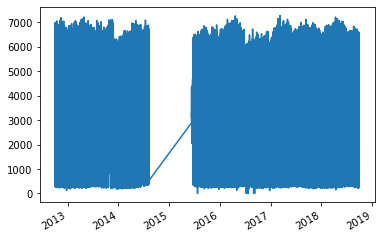

In [8]:
x = ds["date_time"]
y = ds["traffic_volume"]

plt.plot(x, y)
plt.gcf().autofmt_xdate()

In [9]:
ds["year"] = ds['date_time'].dt.year - 2012
months = ds['date_time'].dt.month - 1
weekdays = ds['date_time'].dt.weekday
hours = ds['date_time'].dt.hour

ds.drop(["date_time"], axis=1, inplace=True)

def to_cyclical(a_series, max):
    sin_ = pd.Series(np.sin(2*np.pi*a_series/max), name=f'{a_series.name}_sin')
    cos_ = pd.Series(np.cos(2*np.pi*a_series/max), name=f'{a_series.name}_cos') 
    
    return sin_, cos_

month_sin, month_cos = to_cyclical(months, 11)
ds['month_sin'] = month_sin
ds['month_cos'] = month_cos

weekday_sin, weekday_cos = to_cyclical(weekdays, 6)
ds['weekday_sin'] = weekday_sin
ds['weekday_cos'] = weekday_cos

hour_sin, hour_cos = to_cyclical(hours, 23)
ds['hour_sin'] = hour_sin
ds['hour_cos'] = hour_cos

In [10]:
ds = ds[["traffic_volume", "year", "month_sin", "month_cos", "weekday_sin", "weekday_cos", "hour_sin", "hour_cos", "holiday", "temp", "snow_1h", "clouds_all", "Clear", "Clouds", "Drizzle", "Fog", "Haze", "Mist", "Rain", "Smoke", "Snow", "Squall", "Thunderstorm"]]

In [11]:
ds

traffic_volume  year  month_sin  month_cos   weekday_sin  weekday_cos  \
0                5545     0  -0.909632   0.415415  8.660254e-01          0.5   
1                4516     0  -0.909632   0.415415  8.660254e-01          0.5   
2                4767     0  -0.909632   0.415415  8.660254e-01          0.5   
3                5026     0  -0.909632   0.415415  8.660254e-01          0.5   
4                4918     0  -0.909632   0.415415  8.660254e-01          0.5   
...               ...   ...        ...        ...           ...          ...   
40559            3543     6  -0.989821  -0.142315 -2.449294e-16          1.0   
40560            2781     6  -0.989821  -0.142315 -2.449294e-16          1.0   
40561            2159     6  -0.989821  -0.142315 -2.449294e-16          1.0   
40562            1450     6  -0.989821  -0.142315 -2.449294e-16          1.0   
40563             954     6  -0.989821  -0.142315 -2.449294e-16          1.0   

           hour_sin  hour_cos  holiday    temp  ...  Clouds  Drizzle  Fog  \
0      6.310879e-01 -0.775711        0  288.28  ...       1        0    0   
1      3.984011e-01 -0.917211        0  289.36  ...       1        0    0   
2      1.361666e-01 -0.990686        0  289.58  ...       1        0    0   
3     -1.361666e-01 -0.990686        0  290.13  ...       1        0    0   
4     -3.984011e-01 -0.917211        0  291.14  ...       1        0    0   
...             ...       ...      ...     ...  ...     ...      ...  ...   
40559 -8.878852e-01  0.460065        0  283.45  ...       1        0    0   
40560 -7.308360e-01  0.682553        0  282.76  ...       1        0    0   
40561 -5.195840e-01  0.854419        0  282.73  ...       0        0    0   
40562 -2.697968e-01  0.962917        0  282.09  ...       1        0    0   
40563 -2.449294e-16  1.000000        0  282.12  ...       1        0    0   

       Haze  Mist  Rain  Smoke  Snow  Squall  Thunderstorm  
0         0     0     0      0     0       0             0  
1         0     0     0      0     0       0             0  
2         0     0     0      0     0       0             0  
3         0     0     0      0     0       0             0  
4         0     0     0      0     0       0             0  
...     ...   ...   ...    ...   ...     ...           ...  
40559     0     0     0      0     0       0             0  
40560     0     0     0      0     0       0             0  
40561     0     0     0      0     0       0             1  
40562     0     0     0      0     0       0             0  
40563     0     0     0      0     0       0             0  

[40564 rows x 23 columns]